# Segundo Trabalho de Introdução à Computação Visual

Rita Rezende Borges de Lima<br>
2020065317

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image
from calibration_values import FOCAL_LENGTH_X, FOCAL_LENGTH_Y, PRINCIPAL_POINT_X, PRINCIPAL_POINT_Y, DIST_COEFFS

## Calibração da Câmera

Inicialmente o vídeo passado como entrada foi convertido em uma sequência de imagens utilizando o seguinte [site](https://ezgif.com/video-to-jpg). Os parâmetros de calibração intrínsecos foram obtidos utilizando um dos [toolbox passados em aula](https://github.com/nghiaho12/camera_calibration_toolbox_octave) rodado no __Octave__ versão 5.2.0. Estes foram guardados no arquivo ```calibration_values.py``` que serão lidos em seguida. 

In [2]:
m_int =  np.array([[FOCAL_LENGTH_X, 0.            , PRINCIPAL_POINT_X],
                  [  0.           , FOCAL_LENGTH_Y, PRINCIPAL_POINT_Y],
                  [  0.           , 0.            , 1.               ]])
dist = np.array(DIST_COEFFS)

## Leitura de Entradas

Inicialmente vamos ler as entradas passadas na especificação. Estas constituem de um alvo passado no formato jpg e um vídeo em formato mp4. O primeiro será buscado dentro do último.

O alvo será lido com a função ```imread()``` e binarizado com a função ```threshold()``` da biblioteca __openCV__. O alvo pode ser visto abaixo:

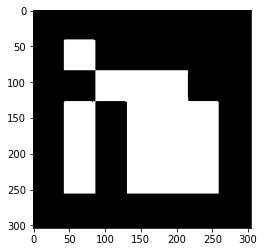

In [3]:
target = cv2.imread('alvo.jpg', cv2.IMREAD_GRAYSCALE)
ret, target = cv2.threshold(target, 128, 255, cv2.THRESH_BINARY)

plt.imshow(target, cmap='gray')
plt.show()

O vídeo será lido com a função ```VideoCapture()``` da biblioteca __openCV__.

In [4]:
video = cv2.VideoCapture('entrada.mp4')

## Detecção do Alvo

Abaixo serão implementadas as funções de detecção do alvo em um frame especifico. Todas foram implementadas utilizando a biblioteca __openCV__. Futuramente serão chamadas no processamento do video, mas para facilidade de teste abaixo serão mostradas funcionando com uma das imagens utilizadas para calibração como entrada.

In [5]:
example_img = cv2.imread('./images/Image2.jpg', cv2.IMREAD_GRAYSCALE)

### Binarização da Imagem

A imagem agora terá apenas dois valores de pixel, preto e branco, para isso foi utilizada a função ```threshold()``` e o parâmetro limite foi o teto da divisão de $\frac{255}{2}$ que por sua vez é igual a  $128$.

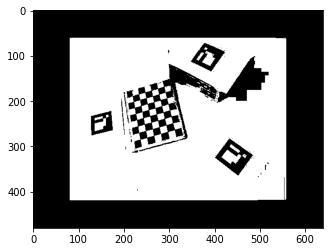

In [6]:
def make_frame_binary(img):
    ret, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    return img

binary_img = make_frame_binary(example_img)
plt.imshow(binary_img, cmap='gray')
plt.show()

### Busca por Bordas

Com a função ```findContours()``` da __openCV__ é possível obter bordas da imagem já binarizada. Para isso passamos os parâmetros RETR_LIST de modo que todos os contornos da aplicação sejam retornados sem uma ordem particular e CHAIN_APROX_SIMPLE que retorna apenas os vértices do contorno. Mais detalhes da função podem ser encontrados [aqui](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html). A função implementada ```find_contours()``` busca retorna todos os contornos encontrados e a imagem com esses em destaque caso o parâmetro opcional ```plot_img``` tenha valor positivo.

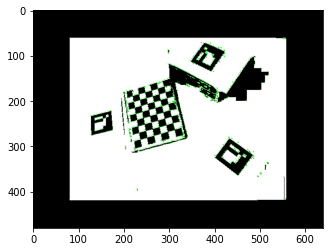

In [7]:
def find_contours(img, plot_img = False):
    
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    img2 = cv2.merge((img,img,img))  
    
    if plot_img:
        for c in contours:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.04 * peri, True)
            for pos in c:
                x = pos[0][1] - 1; y = pos[0][0] - 1
                img2[x][y] = [0, 255, 0]
    
    return contours, img2


contours, img_highlighted_borders = find_contours(binary_img, plot_img = True)
plt.imshow(img_highlighted_borders, cmap='gray')
plt.show()  

### Busca por Quadrados

A lógica para encontrar os quadrados foi baseada no seguinte [tutorial](https://pyimagesearch.com/2016/02/08/opencv-shape-detection/) e no seguinte [post do stack overflow](https://stackoverflow.com/questions/60178004/what-is-the-result-of-arclength-for-a-contour). A função implementada ```find_squares()``` busca por polígonos de 4 vértices que possuam área mínima e máxima especificada por parâmetros. Ela retorna os quadrados que possivelmente possuem alvos e a imagem com esses em destaque caso o parâmetro opcional ```plot_img``` tenha valor positivo.

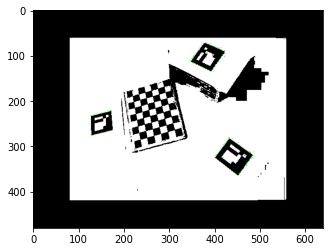

In [8]:
def find_squares(img, contours, plot_img = False, n_of_vertices = 4, min_area = 500):
    
    max_area = img.shape[0] *img.shape[1]/2
    img2 = cv2.merge((img,img,img))  # creat RGB image from grayscale
    squares = []
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        if(len(approx) == n_of_vertices and cv2.contourArea(approx) > min_area and cv2.contourArea(approx) < max_area): 
            squares.append(approx.reshape(-1, 2))
            
            if plot_img:
                for pos in c:
                    x = pos[0][1] - 1; y = pos[0][0] - 1
                    img2[x][y] = [0, 255, 0]
            
            
    return np.array(squares), img2


squares, img_highlighted_squares = find_squares(binary_img, contours, plot_img = True)

plt.imshow(img_highlighted_squares, cmap='gray')
plt.show()  

### Busca por Alvo com Homografia

lorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsumlorem ipsum 

#### Retificando Alvos
[tutorial used for homography](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html) <br>
[tutorial used for warp perspective](https://pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/).

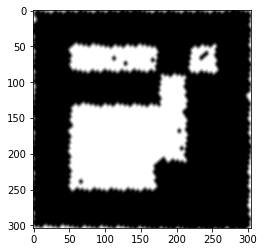

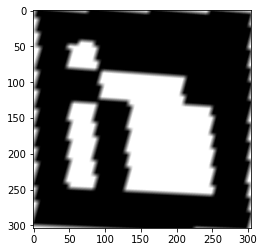

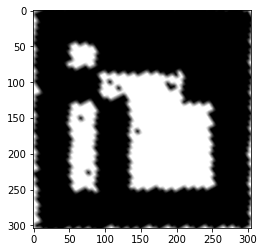

In [9]:
def square_rectification(img, squares, plot_img = False): 
    
    warps = []
    for s in squares:
        h, w = target.shape
        M, mask = cv2.findHomography(s, np.array([[0,0], [w-1, 0], [w-1, h-1], [0, h-1]]), cv2.RANSAC, 5.0)
        warp = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)  
        warps.append(warp)
        
        if plot_img:
            plt.imshow(warp, cmap='gray')
            plt.show() 
        
    return warps

rectified_squares = square_rectification(binary_img, squares, plot_img = True)

#### Detectando Orientação do Alvo

A função de erro ```mse```, do inglês Mean Squared Error foi retirada do seguinte [tutorial](https://pyimagesearch.com/2014/09/15/python-compare-two-images/). A rotação dos quadrados foi realizada baseada na seguinte [fonte](https://learnopencv.com/image-rotation-and-translation-using-opencv/).

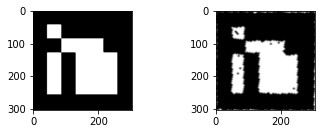

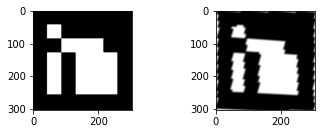

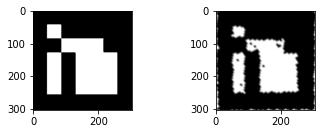

In [10]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])*256

    return err
    
   
    
def find_rotation(rectified_squares, lim = 20, plot_img = False):
    
    correct_squares = []; correct_rotations = []
    for square in rectified_squares:
        width, height = square.shape
        for angle in [90, 180, 270, 360]:
            rotate_matrix = cv2.getRotationMatrix2D((height/2, width/2), angle, 1)
            rotated_square = cv2.warpAffine(square, rotate_matrix, (width, height))
            if mse(rotated_square, target) < lim:
                correct_squares.append(square); correct_rotations.append(angle)
                if plot_img:
                    fig = plt.figure()
                    ax1 = fig.add_subplot(2,2,1)
                    ax1.imshow(target, cmap='gray')
                    ax2 = fig.add_subplot(2,2,2)
                    ax2.imshow(rotated_square, cmap='gray')
                    plt.show() 
                
    return correct_squares, correct_rotations

correct_squares, correct_rotations = find_rotation(rectified_squares, plot_img = True)

## Obtendo a Pose da Câmera

Mais um [tutorial da OpenCV](https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html) e a compreensão da função ```solvePnP()``` vem [daqui](https://www.pythonpool.com/opencv-solvepnp/#:~:text=OpenCV%20solvePnP%20is%20mainly%20used,activity%20by%20observing%20their%20gestures.).

match:


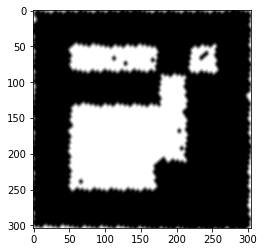

obj =  [[-1. -1.  1.]
 [-1.  1.  1.]
 [ 1.  1.  1.]
 [ 1. -1.  1.]]


error: OpenCV(4.5.5) /io/opencv/modules/calib3d/src/solvepnp.cpp:831: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [11]:
def get_vertices(angle):
    return {
        90:  np.array([[-1,-1,1], [-1,1,1], [1,1,1], [1,-1,1]]).astype(float),
        180: np.array([[1,-1,1], [-1,-1,1], [-1,1,1], [1,1,1]]).astype(float),
        270: np.array([[-1,1,1], [1,1,1], [1,-1,1], [-1,-1,1]]).astype(float),
        360: np.array([[1,1,1], [1,-1,1], [-1,-1,1], [-1,1,1]]).astype(float)
    }[angle]
    

def find_poses(correct_squares, correct_rotations, plot_img = False):
    result = []
    for idx, square in enumerate(correct_squares):
        
        if plot_img:
            print("match:")
            plt.imshow(square, cmap='gray')
            plt.show() 
        
            print("obj = ", get_vertices(correct_rotations[idx]))
       
        ret, rvecs, tvecs = cv2.solvePnP(get_vertices(correct_rotations[idx]), square.astype(float), m_int, dist)
        if ret:
            result.append({'ret':ret,'rvecs':rvecs,'tvecs':tvecs})
    return result

find_poses(correct_squares, correct_rotations, plot_img = True)

## Renderização com OpenGL